In [1]:
##############################################################
############### Examining average performance across experimental connditionns. vmPFC ablation
##############################################################
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 180
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

import matplotlib.pyplot as plt
import numpy as np
import os, re, sys
import pickle
from tqdm import tqdm
sys.path.append('./../')
file_format= 'JPG'



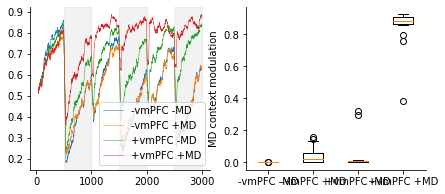

In [2]:
exp_name = 'vmPFC7/vmPFC_ablation'
results_folder = './../results/'
#get files
files = os.listdir( results_folder  + exp_name+'/')
config_files = [file for file in files if 'config' in file]
log_files = [file for file in files if 'log' in file]
exps = {0: '+vmPFC +MD', 1: '+vmPFC -MD', 2:'-vmPFC -MD', 3:'all_off'}
# vars = [(var1, var2) for var1 in [3] for var2 in [0, 1, 2,3,4,5,10,20,30,40,50,100,150,200]]
# vars = [(var1, var2) for var1 in [1] for var2 in [0, 1, 2,3,4,50,100,150,200]]
vars = [(var1, var2) for var1 in [0, 1] for var2 in [0,1,]]
# vars = [(var1, var2) for var1 in [3] for var2 in [0,1, 5, 10,20,30,40,200]]
regexes = [f"\d_{float(var1):1.1f}_{float(var2):1.1f}_0.0" for var1, var2 in vars]  
labels = [f"{'+vmPFC' if var1 else '-vmPFC'} {'+MD' if var2 else '-MD'}" for var1, var2  in vars]

fig, axes = plt.subplots(1,2 , figsize=[18/2.54 ,3])
ax = axes[0]
means, stds, md_modulations = [], [], []
for label, regex in zip (labels, regexes):
    comp_files =  [os.path.join(results_folder+exp_name,file) for file in log_files if re.search(regex, file)]
    conf_files =   [os.path.join(results_folder+exp_name,file) for file in config_files if re.search(regex, file)]
    if len(comp_files) > 0:
        performances, mods =[], []
        for log_file, config_file in zip (comp_files, conf_files):
            log = np.load(log_file, allow_pickle=True).item()
            # if log.md_context_modulation > 0.8 : 
            performances.append(log.corrects)
            mods.append(log.md_context_modulation)
        smooth_performances = [np.convolve(performance, np.ones((40,))/40, mode='full') for performance in performances]
        sp = np.stack(smooth_performances)
        spmean = np.mean(sp, axis=0)    
        spstd = np.std(sp, axis=0)    
        means.append(spmean)
        stds.append(spstd)
        spmean[:40] = np.nan # remove spurious edge effects from convolving to smoothen the signal
        spmean[-40:] = np.nan
        ax.plot(range(len(spmean)), spmean, label=label, linewidth=0.5)
        # ax.fill_between(range(len(spmean)), spmean-spstd, spmean+spstd, alpha=.4)
        md_modulations.append(mods)
        
    else:
        print(f'no files found for {label}')
ax.legend()
tpb= 500
for ib in range(1, 6,2):
            ax.axvspan(tpb* ib, tpb*(ib+1), alpha=0.1, color='grey')
ax = axes[1]
_=ax.boxplot(md_modulations)
ax.set_ylabel('MD context modulation')
ax.set_xticklabels(labels)
plt.savefig('./exports/vmPFC/perf.pdf', dpi=300)

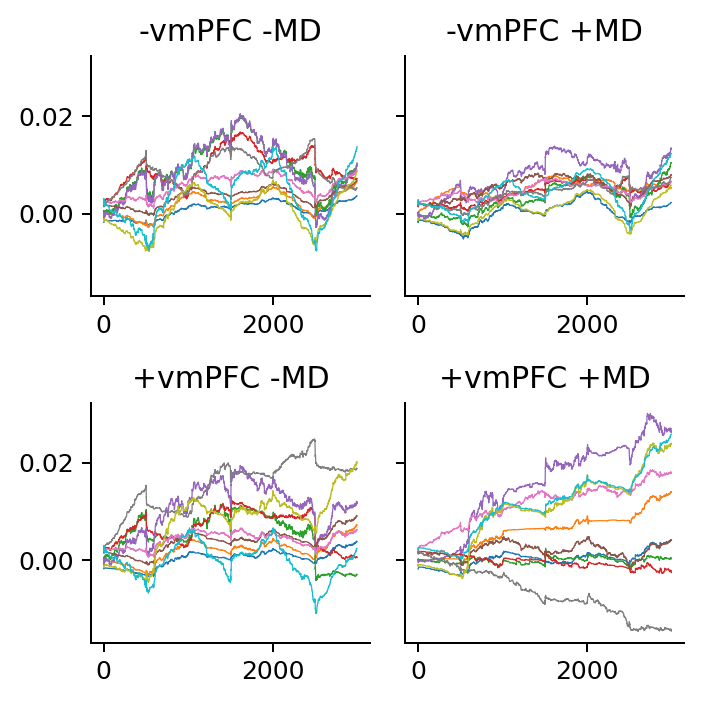

In [18]:
# seeds with detailed saves 11 through 15   0 also but its md modulation is low. 
seed = 11 # 12, 13, 14 ,15
regexes = [f"_{seed}_{float(var1):1.1f}_{float(var2):1.1f}_0.0" for var1, var2 in vars]  
labels = [f"{'+vmPFC' if var1 else '-vmPFC'} {'+MD' if var2 else '-MD'}" for var1, var2  in vars]
fig, axes = plt.subplots(2,2, figsize=[4,4], sharey=True)
i =0
variances = {}
for label, regex in zip (labels, regexes):
    comp_files =  [os.path.join(results_folder+exp_name,file) for file in log_files if re.search(regex, file)]
    conf_files =   [os.path.join(results_folder+exp_name,file) for file in config_files if re.search(regex, file)]
    for log_file, config_file in zip (comp_files, conf_files):
            
            log = np.load(log_file, allow_pickle=True).item()
            # if log.md_context_modulation > 0.8 : 
            if hasattr(log, 'wOuts'):
                ax =axes.flatten()[i]
                ax.plot(log.wOuts[:, 0, :10], linewidth=0.5)
                ax.set_title(label)
                variances.update({label: np.var(log.wOuts[-1,:,:])})
            else: print(f'no weights found for {label}, {regex}!')
            i += 1
fig.tight_layout()            
plt.savefig('./exports/vmPFC/weiughts.pdf', dpi=300)

<Figure size 360x360 with 0 Axes>

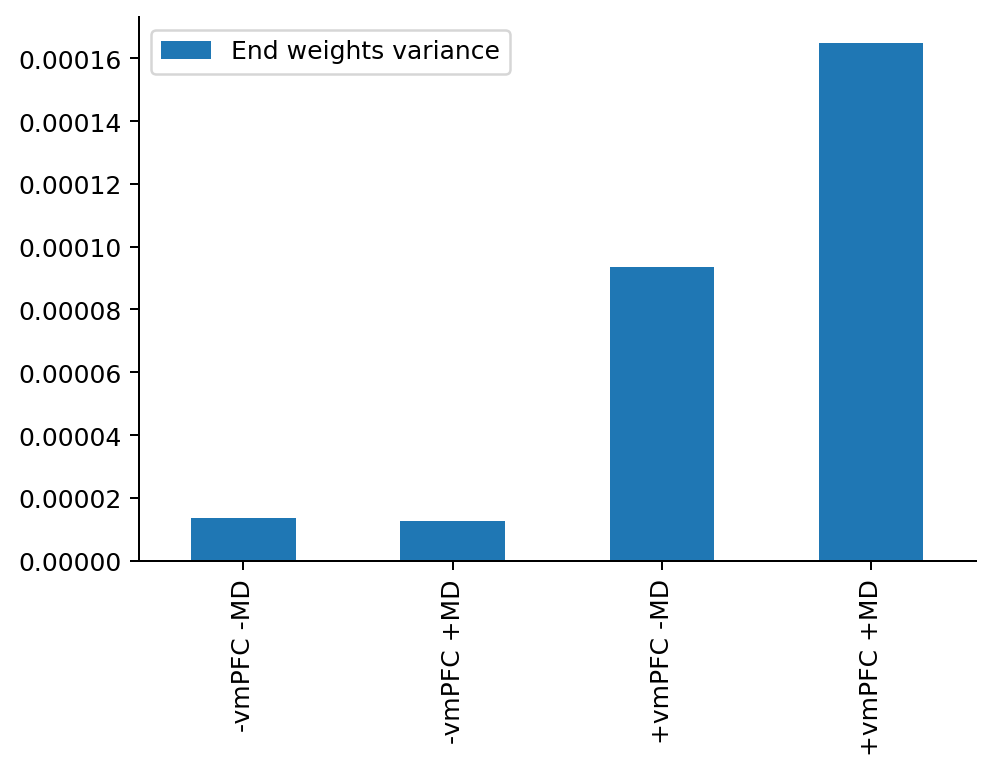

In [19]:
import pandas as pd
myList = variances.items()
myList = sorted(myList, reverse=True)
x, y = zip(*myList)
# pd.Series([65, 61, 25, 22, 27]).plot(kind="bar")
# Create a sample dataframe with an text index
plt.figure(figsize=[2,2])
plotdata = pd.DataFrame(
    {"End weights variance": y}, 
    index=x)
# Plot a bar chart
plotdata.plot(kind="bar")
plt.savefig('./exports/vmPFC/variance.pdf', dpi=300)